Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

#### Надеюсь, можно не обязательно через tensorflow...

In [1]:
! wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/wiki_data.txt

--2024-01-23 19:46:23--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/wiki_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68582461 (65M) [text/plain]
Saving to: 'wiki_data.txt'

wiki_data.txt       100%[===================>]  65.41M   294MB/s    in 0.2s    

2024-01-23 19:46:25 (294 MB/s) - 'wiki_data.txt' saved [68582461/68582461]



In [2]:
! pip install razdel pymystem3 -q

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import razdel
from string import punctuation
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
%matplotlib inline
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
texts = open("./wiki_data.txt").read().split("\n")

In [5]:
import re
import pymystem3

m = pymystem3.Mystem()

def preprocess(text):

    pattern1 = re.compile(r"#+")
    pattern2 = re.compile("\w+")

    tokens = re.sub(pattern1, ' ', text.lower())
    tokens = m.lemmatize(tokens)
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if re.match(pattern2, token)]
    return tokens

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [62]:
vocab = Counter()

for text in texts:
    vocab.update(preprocess(text))

len(vocab)

184366

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 20:
        filtered_vocab.add(word)

len(filtered_vocab)

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
MAX_LEN = 0
texts2ids = []

for text in texts:
    tokens = preprocess(text)
    MAX_LEN = max(len(tokens), MAX_LEN)
    ids = [word2id[token] for token in tokens if token in word2id]
    texts2ids.append(ids)


In [ ]:
MAX_LEN

In [ ]:
MAX_LEN = 9000

In [ ]:
WINDOW_SIZE = 6

In [14]:
X = []
y = []


for sent in texts2ids:
    sent = sent[:MAX_LEN]
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-WINDOW_SIZE):i] + sent[i+1:i+WINDOW_SIZE]


        for context_word in context:
            X.append(word)
            y.append(context_word)


In [15]:
len(X), len(y)

(49749490, 49749490)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Naive pytorch inplementation -- no negative sampling, Skip-gram (trains too long)

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):

        self.data = torch.tensor([X, Y], dtype=torch.long)

    def __len__(self):
        return self.data.size()[1]

    def __getitem__(self, index):

        X=self.data[0, index]
        y=self.data[1, index]

        return X, y

#### NN

In [ ]:
from torchsummary import summary

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
model = nn.Sequential(
    nn.Linear(in_features=len(word2id), out_features=300),
    nn.Flatten(),
    nn.Linear(in_features=300, out_features=len(word2id)),
    nn.Softmax(dim=1)
).to(device)

In [ ]:
summary(model, (1, len(word2id)), batch_size=1024)

In [ ]:
train_data = Dataset(X_train, y_train)
test_data = Dataset(X_test, y_test)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=8192, drop_last=True, shuffle=True, num_workers=10)
test_loader = DataLoader(test_data, batch_size=8192, drop_last=True, shuffle=False, num_workers=10)


In [ ]:
def train(model, dataloader, optimizer, criterion, print_every=1000):
    epoch_loss = 0
    model.train()

    for i, (Xs, ys) in tqdm(enumerate(dataloader)):

        optimizer.zero_grad()

        predictions = model(Xs.to(device)).squeeze()

        loss = criterion(predictions.float(), ys.to(device).float())

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}')

    return epoch_loss / len(dataloader)

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for Xs, ys in iterator:

            predictions = model(Xs.to(device)).squeeze()
            loss = criterion(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-1)
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
EPOCHS = 20

In [ ]:
losses = []
losses_eval = []

for i in range(EPOCHS):
    print(f"Epoch: {i}")
    losses.append(train(model, train_loader, optimizer, criterion))
    losses_eval.append(evaluate(model, test_loader, criterion))

### Try tensorflow

In [17]:
import tensorflow as tf

In [18]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word2id),
                                    input_length=1,
                                    output_dim=250))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(len(word2id),
                                activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss='sparse_categorical_crossentropy',
              )

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 250)            4250000   
                                                                 
 flatten (Flatten)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 17000)             4267000   
                                                                 
Total params: 8517000 (32.49 MB)
Trainable params: 8517000 (32.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=8192,
         epochs=15)

model.save("skipgram.keras")

Epoch 1/15
5466/5466 [==============================] - 415s 75ms/step - loss: 7.3887 - val_loss: 7.2132
Epoch 2/15
5466/5466 [==============================] - 312s 57ms/step - loss: 7.1652 - val_loss: 7.1602
Epoch 3/15
5466/5466 [==============================] - 311s 56ms/step - loss: 7.1147 - val_loss: 7.1459
Epoch 4/15
5466/5466 [==============================] - 311s 56ms/step - loss: 7.0866 - val_loss: 7.1429
Epoch 5/15
5466/5466 [==============================] - 310s 56ms/step - loss: 7.0680 - val_loss: 7.1440
Epoch 6/15
5466/5466 [==============================] - 310s 56ms/step - loss: 7.0545 - val_loss: 7.1468
Epoch 7/15
5466/5466 [==============================] - 310s 56ms/step - loss: 7.0446 - val_loss: 7.1503
Epoch 8/15
5466/5466 [==============================] - 311s 56ms/step - loss: 7.0370 - val_loss: 7.1533
Epoch 9/15
5466/5466 [==============================] - 309s 56ms/step - loss: 7.0311 - val_loss: 7.1562
Epoch 10/15
5466/5466 [==============================] 

dict_keys(['loss', 'val_loss'])


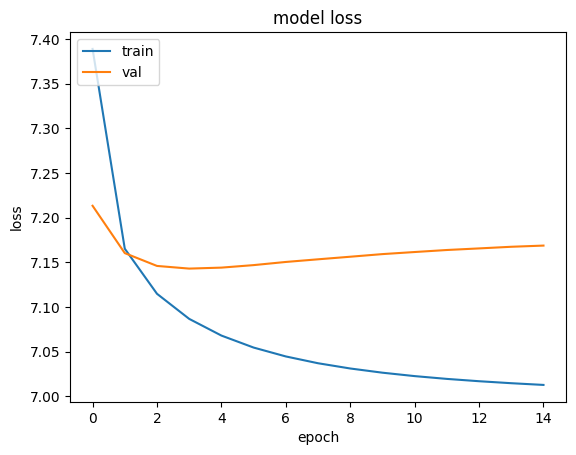

In [22]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Протестируем на первой матрице эмбедингов

In [23]:
embeddings = model.layers[0].get_weights()[0]

In [24]:
def most_similar(word, embeddings, n):
    similar = [id2word[i] for i in 
               cosine_similarity(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:n]]
    return similar

In [25]:
most_similar("люк", embeddings, 15)

['узбек',
 'наместничество',
 'малочисленный',
 'памирский',
 'кайгы',
 'область',
 'киргизия',
 'родство',
 'основоположник',
 'происхождение',
 'повет',
 'вслед',
 'эстонец',
 'PAD',
 '186']

In [26]:
most_similar('рыбный', embeddings, 15)

['норман',
 'словно',
 'вертикаль',
 'PAD',
 'шестерка',
 'coal',
 'густаво',
 'укол',
 'chamber',
 'пары',
 'пауль',
 'allmusic',
 'молчание',
 'настояние',
 'выбивать']

### CBOW

In [27]:
WINDOW_SIZE = 7

X = []
y = []


for sent in texts2ids:
    sent = sent[:MAX_LEN]
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-WINDOW_SIZE):i] + sent[i+1:i+WINDOW_SIZE]
        
        X.append(context)
        y.append(word)


In [28]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=14, padding='post')
y = np.array(y)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [30]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=14, 
                                    output_dim=250))
model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))
model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.03),
              loss='sparse_categorical_crossentropy',)

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 14, 250)           4250000   
                                                                 
 lambda (Lambda)             (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 17000)             4267000   
                                                                 
Total params: 8517000 (32.49 MB)
Trainable params: 8517000 (32.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          batch_size=8192,
         epochs=15)

model.save("cbow.keras")

Epoch 1/15
503/503 [==============================] - 77s 152ms/step - loss: 7.1582 - val_loss: 6.4875
Epoch 2/15
503/503 [==============================] - 38s 76ms/step - loss: 6.1853 - val_loss: 6.0557
Epoch 3/15
503/503 [==============================] - 33s 67ms/step - loss: 5.8014 - val_loss: 5.8741
Epoch 4/15
503/503 [==============================] - 31s 61ms/step - loss: 5.5633 - val_loss: 5.7863
Epoch 5/15
503/503 [==============================] - 32s 63ms/step - loss: 5.3903 - val_loss: 5.7426
Epoch 6/15
503/503 [==============================] - 31s 61ms/step - loss: 5.2527 - val_loss: 5.7231
Epoch 7/15
503/503 [==============================] - 31s 61ms/step - loss: 5.1379 - val_loss: 5.7190
Epoch 8/15
503/503 [==============================] - 30s 60ms/step - loss: 5.0393 - val_loss: 5.7252
Epoch 9/15
503/503 [==============================] - 30s 60ms/step - loss: 4.9532 - val_loss: 5.7369
Epoch 10/15
503/503 [==============================] - 30s 60ms/step - loss: 4.87

dict_keys(['loss', 'val_loss'])


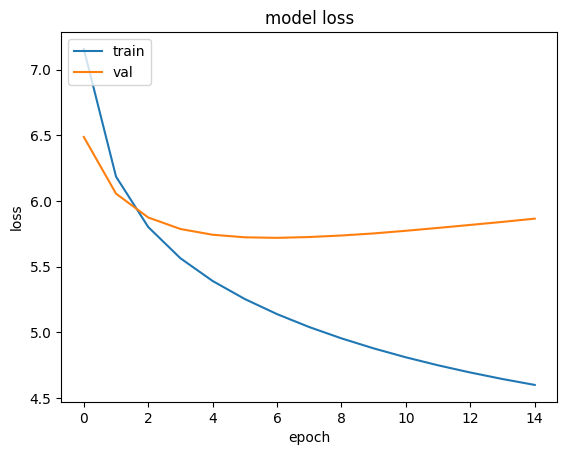

In [33]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Очень похоже, что в обоих случаях мы переобучаемся -- можно ставить поменьше эпох или регуляризировать обучение -- решим эти вопросы готовой реализацией в **gensim**

Тут для интереса возьмем обе матрицы и усредним

In [34]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [35]:
most_similar("люк", embeddings, 15)

['считать',
 'малочисленный',
 'алфавитный',
 'славянин',
 'славянский',
 'hurts',
 'рыбинск',
 'лициния',
 'моральный',
 'фольклор',
 'эстонец',
 'хронология',
 'народ',
 'костусев',
 'черноморец']

In [36]:
most_similar('рыбный', embeddings, 15)

['пауза',
 'вертикаль',
 'обоюдный',
 'неизбежно',
 'полуфинальный',
 'подбирать',
 'пробивать',
 'полуфинал',
 'allmusic',
 'суждение',
 'атр',
 'заряжать',
 'сборная',
 'игрок',
 'навстречу']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [63]:
import gensim

In [17]:
text_list = [preprocess(text) for text in texts]

#### word2vec

In [40]:
%%time

w2v = gensim.models.Word2Vec(text_list,)

CPU times: user 1min 15s, sys: 0 ns, total: 1min 15s
Wall time: 28.7 s


In [41]:
w2v.wv.most_similar("люк")

[('крышка', 0.8916254043579102),
 ('дверь', 0.8303139805793762),
 ('бак', 0.8276918530464172),
 ('бампер', 0.8229833245277405),
 ('кабина', 0.8228425979614258),
 ('багажник', 0.820930004119873),
 ('сзади', 0.820038914680481),
 ('контейнер', 0.8190492987632751),
 ('резиновый', 0.816397488117218),
 ('рама', 0.8158614635467529)]

In [42]:
w2v.wv.most_similar("рыбный")

[('промысел', 0.8029521703720093),
 ('молочный', 0.8029253482818604),
 ('скотоводство', 0.7934920191764832),
 ('животноводство', 0.7904418110847473),
 ('земледелие', 0.7852758169174194),
 ('зерновой', 0.779317319393158),
 ('тростник', 0.7782313823699951),
 ('лесной', 0.7773268818855286),
 ('ловля', 0.7749549150466919),
 ('текстильный', 0.7632588148117065)]

In [43]:
%%time
w2v = gensim.models.Word2Vec(text_list,
                            vector_size = 400, #размер вектора
                            min_count = 20, # минимум вхождений в словарь
                            max_vocab_size = 30000, # макс размер словаря
                            window = 11, # окно
                            sg = 0, # skipgram
                            hs = 1, # hierarchical softmax
                            sample = 1e-4, # даунсэмплинг частотных слов
                            cbow_mean = 0, # взять сумму по компонентам вектора
                            epochs = 30 # кол-во эпох
                            )

CPU times: user 18min 34s, sys: 111 ms, total: 18min 34s
Wall time: 6min 30s


In [44]:
w2v.wv.most_similar("люк")

[('который', 0.4816998541355133),
 ('и', 0.45939216017723083),
 ('также', 0.4592028260231018),
 ('только', 0.4562213122844696),
 ('два', 0.44471850991249084),
 ('в', 0.4439891576766968),
 ('система', 0.44367334246635437),
 ('на', 0.4419732689857483),
 ('по', 0.44063878059387207),
 ('она', 0.43879759311676025)]

In [45]:
w2v.wv.most_similar("рыбный")

[('лесной', 0.3600001335144043),
 ('рыба', 0.3569331169128418),
 ('соляной', 0.3544541597366333),
 ('война', 0.35173821449279785),
 ('молочный', 0.34453877806663513),
 ('населенный', 0.3428890109062195),
 ('восток', 0.34233492612838745),
 ('второй', 0.3410261571407318),
 ('который', 0.33121129870414734),
 ('зависимость', 0.3309754431247711)]

In [49]:
w2v.save("w2v_gensim.model")

#### fasttext

In [46]:
%%time
ft = gensim.models.FastText(text_list,)

CPU times: user 6min 19s, sys: 0 ns, total: 6min 19s
Wall time: 2min 14s


In [47]:
ft.wv.most_similar("люк")

[('люкс', 0.8449093699455261),
 ('эл', 0.75230872631073),
 ('фотон', 0.7452394366264343),
 ('клайн', 0.7448855042457581),
 ('лайнус', 0.7374355792999268),
 ('пирс', 0.7284163236618042),
 ('элизабета', 0.7273173332214355),
 ('клеймо', 0.720865786075592),
 ('клейн', 0.7193921208381653),
 ('рис', 0.718586802482605)]

In [48]:
ft.wv.most_similar("рыбный")

[('зубный', 0.9624884724617004),
 ('юпаный', 0.956599771976471),
 ('змеиный', 0.9545458555221558),
 ('хищный', 0.949390172958374),
 ('шубиный', 0.9490553140640259),
 ('хлебный', 0.9473191499710083),
 ('жирный', 0.9467923045158386),
 ('лобный', 0.9466269016265869),
 ('ярусный', 0.9444992542266846),
 ('кукурузный', 0.9434624314308167)]

In [18]:
%%time
ft = gensim.models.FastText(text_list, 
                            min_count = 20, 
                            max_vocab_size=30000,
                            vector_size=400, 
                            hs=1, 
                            sample=1e-4, 
                            min_n=2, 
                            max_n=5, 
                            epochs=15
                           )

CPU times: user 1h 1min 10s, sys: 3.52 s, total: 1h 1min 14s
Wall time: 20min 39s


In [19]:
ft.wv.most_similar("люк")

[('крюк', 0.4459476172924042),
 ('крышка', 0.4263637661933899),
 ('трюк', 0.4114026725292206),
 ('биюк', 0.3751354515552521),
 ('лю', 0.34751179814338684),
 ('дверь', 0.3463723659515381),
 ('крыша', 0.3456104099750519),
 ('отсек', 0.3390488028526306),
 ('окно', 0.33473846316337585),
 ('люксембург', 0.33234602212905884)]

In [20]:
ft.wv.most_similar("рыбный")

[('рыбак', 0.6114777326583862),
 ('рыба', 0.6025224924087524),
 ('рыбацкий', 0.5758329629898071),
 ('рыболовство', 0.5272467732429504),
 ('хлебный', 0.49912911653518677),
 ('ловля', 0.4051220417022705),
 ('промысел', 0.3824951946735382),
 ('пресноводный', 0.37361037731170654),
 ('удобный', 0.34902653098106384),
 ('пресный', 0.3390463888645172)]

In [21]:
ft.save("fasttext_gensim.model")

Вообще даже тут явно не хватает объема корпуса -- на менее частотных словах fasttext скатывается к поиску ближайших по энграммам -- хотя это общая проблема языковых моделей для лексики с низкой частотностью. W2V просто предсказыавет случайные частотные токены, fasttext - близкие энгаммы. Наиболее подходящее решение все равно под задачу подбирать

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019).
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [6]:
! pip install corpy

  Obtaining dependency information for ufal.morphodita>=1.10 from https://files.pythonhosted.org/packages/1b/77/152f54ae9ac8f81f54a2e83a1e21142ad1db89f09c0a755435e9e037393f/ufal.morphodita-1.11.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for ufal.udpipe>=1.2 from https://files.pythonhosted.org/packages/47/95/6b709dbd9f4b7ea53a2f80a45ecb06c645be7677fd47b7a0210feca2c39f/ufal.udpipe-1.3.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.5/425.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.8/936.8 kB 41.3 MB/s eta 0:00:00


In [7]:
import corpy
import pandas as pd
import gensim
import tensorflow as tf

In [8]:
!wget https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/labeled.csv

--2024-01-23 19:47:23--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/word_embeddings/labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4669913 (4.5M) [text/plain]
Saving to: 'labeled.csv'

labeled.csv         100%[===================>]   4.45M  --.-KB/s    in 0.07s   

2024-01-23 19:47:23 (66.8 MB/s) - 'labeled.csv' saved [4669913/4669913]



In [17]:
! wget http://vectors.nlpl.eu/repository/20/213.zip

--2024-01-23 19:54:07--  http://vectors.nlpl.eu/repository/20/213.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485270300 (1.4G) [application/zip]
Saving to: '213.zip'

213.zip             100%[===================>]   1.38G  16.9MB/s    in 85s     

2024-01-23 19:55:33 (16.6 MB/s) - '213.zip' saved [1485270300/1485270300]



In [18]:
! unzip -d geowac_lemmas_none_fasttextskipgram_300_5_2020 213.zip 

Archive:  213.zip
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/meta.json  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors_ngrams.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model.vectors_vocab.npy  
  inflating: geowac_lemmas_none_fasttextskipgram_300_5_2020/README  


In [10]:
! cat geowac_lemmas_none_fasttextskipgram_300_5_2020/meta.json

cat: geowac_lemmas_none_fasttextskipgram_300_5_2020/meta.json: No such file or directory


In [38]:
st_w2v_cbow = tf.keras.models.load_model("/kaggle/input/models-st-emb/cbow.keras", safe_mode=False)
st_w2v_cbow.weights[0].shape

TensorShape([17000, 250])

In [37]:
st_w2v_skip = tf.keras.models.load_model("/kaggle/input/models-st-emb/skipgram.keras", safe_mode=False)
st_w2v_skip.weights[0].shape

TensorShape([17000, 250])

In [41]:
gensim_w2v = gensim.models.Word2Vec.load("/kaggle/input/models-st-emb/w2v_gensim.model")
gensim_w2v.vector_size

400

In [42]:
gensim_ft = gensim.models.FastText.load("/kaggle/input/models-st-emb/fasttext_gensim/fasttext_gensim.model")
gensim_ft.vector_size

400

In [43]:
pretrained_ft = gensim.models.keyedvectors.FastTextKeyedVectors.load("geowac_lemmas_none_fasttextskipgram_300_5_2020/model.model")
pretrained_ft.vector_size

300

In [20]:
data = pd.read_csv('labeled.csv')

In [21]:
data['norm_text'] = data.comment.apply(preprocess)

In [22]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд, то, за, что, дебил, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачий, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновлять, дебил, это, тоже, не, ос..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убеждать, 6, страничный, пдф, в, то, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибегать, и, ныть, ..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что, ли, и..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотреть, утомленный, солнце, 2, и, оказыва..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, т, к, в..."


In [23]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6310

In [24]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [46]:
len(word2id)

6311

In [25]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [26]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [34]:
def get_embeddings(model, word2id, model_type, emb_dim):

    weights = np.zeros((len(word2id), emb_dim))

    for word, i in word2id.items():
        # вектор паддинга оставим нулевым
        if word == 'PAD':
            continue

        match model_type:
            case "gensim":
                try:
                    weights[i] = model.wv[word]


                except KeyError:
                    # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
                    continue
                    weights[i] = model.wv["f"]

            case "pretrained":
                try:
                    weights[i] = model.get_vector(word)


                except KeyError:
                    # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
                    continue
                    weights[i] = model.get_vector("фаввввн")

            case "self-trained":
                try:
                    weights[i] = model.weights[0][word2id[word]]


                except KeyError:
                    # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
                    continue
                    weights[i] = model.weights[0][word2id["PAD"]]

    return weights

### Selt-trained

In [54]:
EMB_DIM = 250

In [55]:
emb = get_embeddings(st_w2v_cbow, word2id, "self-trained", EMB_DIM)

In [56]:
emb.shape

(6311, 250)

In [57]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=EMB_DIM, 
                                       trainable=False,
                                       weights=[emb])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [60]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=50)

Epoch 1/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5583 - accuracy: 0.7127 - val_loss: 0.5551 - val_accuracy: 0.7115
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5573 - accuracy: 0.7142 - val_loss: 0.5542 - val_accuracy: 0.7115
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5565 - accuracy: 0.7140 - val_loss: 0.5535 - val_accuracy: 0.7184
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5557 - accuracy: 0.7153 - val_loss: 0.5525 - val_accuracy: 0.7184
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5548 - accuracy: 0.7151 - val_loss: 0.5517 - val_accuracy: 0.7191
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5541 - accuracy: 0.7168 - val_loss: 0.5509 - val_accuracy: 0.7198
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5533 - accuracy: 0.7170 - val_loss: 0.5503 - val_accuracy: 0.7226
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


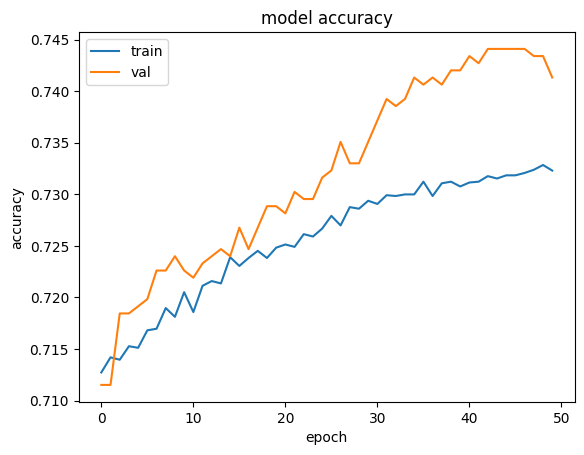

In [62]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
emb = get_embeddings(st_w2v_skip, word2id, "self-trained", EMB_DIM)

In [64]:
emb.shape

(6311, 250)

In [65]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=EMB_DIM, 
                                       trainable=False,
                                       weights=[emb])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [66]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=50)

Epoch 1/50
406/406 [==============================] - 2s 3ms/step - loss: 0.6268 - accuracy: 0.6646 - val_loss: 0.6175 - val_accuracy: 0.6678
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6172 - accuracy: 0.6648 - val_loss: 0.6136 - val_accuracy: 0.6678
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6136 - accuracy: 0.6648 - val_loss: 0.6097 - val_accuracy: 0.6678
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6099 - accuracy: 0.6648 - val_loss: 0.6061 - val_accuracy: 0.6678
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6066 - accuracy: 0.6648 - val_loss: 0.6029 - val_accuracy: 0.6678
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6034 - accuracy: 0.6653 - val_loss: 0.5997 - val_accuracy: 0.6685
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6004 - accuracy: 0.6655 - val_loss: 0.5967 - val_accuracy: 0.6692
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


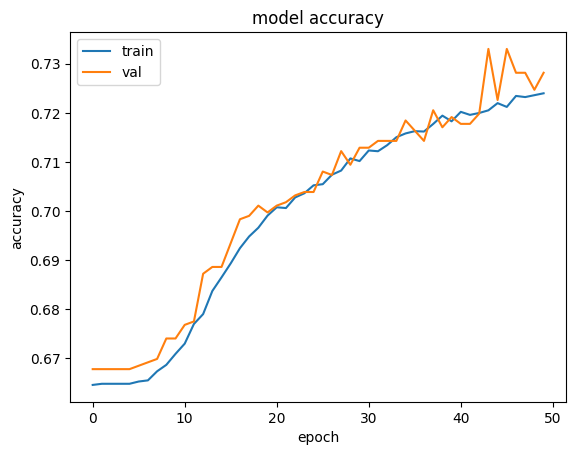

In [67]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Gensim

In [68]:
EMB_DIM = 400

In [69]:
emb = get_embeddings(gensim_w2v, word2id, "gensim", EMB_DIM)

In [70]:
emb.shape

(6311, 400)

In [71]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=EMB_DIM, 
                                       trainable=False,
                                       weights=[emb])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [72]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=50)

Epoch 1/50
406/406 [==============================] - 2s 3ms/step - loss: 0.6289 - accuracy: 0.6591 - val_loss: 0.6111 - val_accuracy: 0.6678
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6116 - accuracy: 0.6648 - val_loss: 0.6081 - val_accuracy: 0.6678
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6089 - accuracy: 0.6648 - val_loss: 0.6054 - val_accuracy: 0.6678
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6061 - accuracy: 0.6648 - val_loss: 0.6027 - val_accuracy: 0.6678
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6033 - accuracy: 0.6648 - val_loss: 0.6000 - val_accuracy: 0.6678
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.6005 - accuracy: 0.6648 - val_loss: 0.5976 - val_accuracy: 0.6678
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5980 - accuracy: 0.6648 - val_loss: 0.5950 - val_accuracy: 0.6678
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


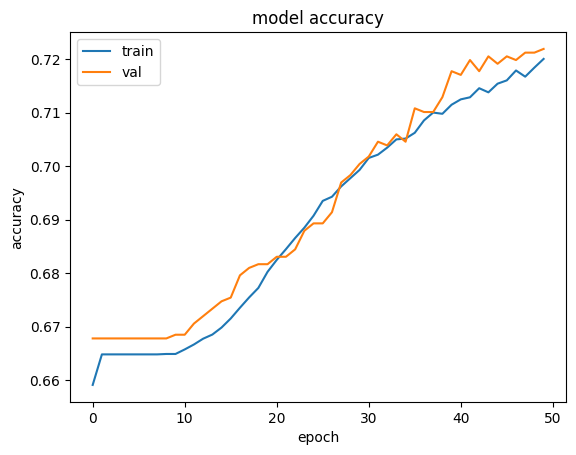

In [73]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [74]:
EMB_DIM = 400

In [75]:
emb = get_embeddings(gensim_ft, word2id, "gensim", EMB_DIM)

In [76]:
emb.shape

(6311, 400)

In [77]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=EMB_DIM, 
                                       trainable=False,
                                       weights=[emb])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [78]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=50)

Epoch 1/50
406/406 [==============================] - 2s 3ms/step - loss: 0.6065 - accuracy: 0.6679 - val_loss: 0.5756 - val_accuracy: 0.6872
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5583 - accuracy: 0.7075 - val_loss: 0.5466 - val_accuracy: 0.7178
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5345 - accuracy: 0.7263 - val_loss: 0.5283 - val_accuracy: 0.7351
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5189 - accuracy: 0.7347 - val_loss: 0.5155 - val_accuracy: 0.7483
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.7442 - val_loss: 0.5049 - val_accuracy: 0.7531
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.4985 - accuracy: 0.7525 - val_loss: 0.4972 - val_accuracy: 0.7649
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.4912 - accuracy: 0.7577 - val_loss: 0.4901 - val_accuracy: 0.7649
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


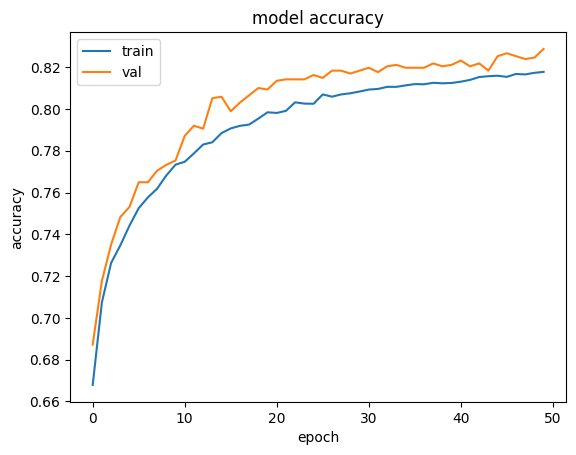

In [80]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Pretrained

In [97]:
import spacy_udpipe

spacy_udpipe.download("ru")

Downloaded pre-trained UDPipe model for 'ru' language


In [85]:
data = pd.read_csv('labeled.csv')

In [123]:

def preprocess(text):

    pattern1 = re.compile(r"#+")
    pattern2 = re.compile("\w+")

    tokens = re.sub(pattern1, ' ', text.lower())
    doc = model(tokens)
    
    toks = []
    for token in doc:
        if re.match("\w+",token.lemma_):
            toks.append(token.lemma_)
        else:
            continue
    return toks

In [124]:
data['norm_text'] = data.comment.apply(preprocess)

In [125]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюд, то, за, что, дебил, бть]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохол, это, отдушина, затюканый, россиянин, м..."
2,Собаке - собачья смерть\n,1.0,"[собака, собачье, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страница, обновить, дебить, это, тоже, не, ос..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[ты, не, убедить, 6-страничный, пдф, в, то, чт..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибегнуть, и, ныть,..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кто, любить, гоблин, тупорылый, что-ль, ил..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[смотреть, утомить, солнце, 2, и, оказаться, ч..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушать, правило, раздел, так, к,..."


In [127]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

6092

In [128]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [129]:
len(word2id)

6093

In [130]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [131]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

In [132]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [133]:
EMB_DIM = 300

In [134]:
emb = get_embeddings(pretrained_ft, word2id, "pretrained", EMB_DIM)

In [135]:
emb.shape

(6093, 300)

In [136]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# # обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=EMB_DIM, 
                                       trainable=False,
                                       weights=[emb])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [137]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=50)

Epoch 1/50
406/406 [==============================] - 2s 3ms/step - loss: 0.6225 - accuracy: 0.6621 - val_loss: 0.6083 - val_accuracy: 0.6498
Epoch 2/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5960 - accuracy: 0.6668 - val_loss: 0.5898 - val_accuracy: 0.6498
Epoch 3/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5793 - accuracy: 0.6672 - val_loss: 0.5730 - val_accuracy: 0.6526
Epoch 4/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5643 - accuracy: 0.6704 - val_loss: 0.5582 - val_accuracy: 0.6595
Epoch 5/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5508 - accuracy: 0.6777 - val_loss: 0.5447 - val_accuracy: 0.6755
Epoch 6/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5387 - accuracy: 0.6904 - val_loss: 0.5329 - val_accuracy: 0.6893
Epoch 7/50
406/406 [==============================] - 1s 3ms/step - loss: 0.5277 - accuracy: 0.7076 - val_loss: 0.5221 - val_accuracy: 0.7039
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


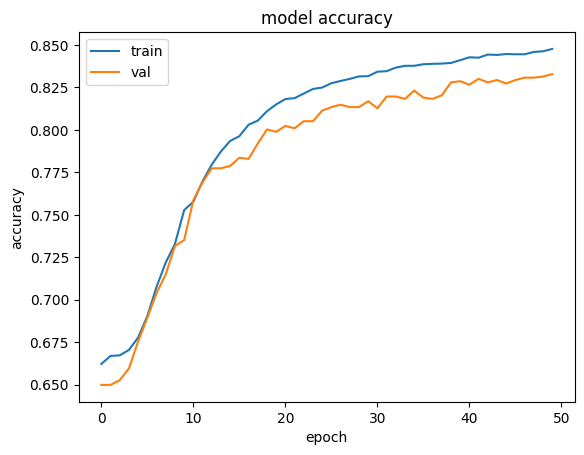

In [139]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()